In [1]:
import os
import numpy as np
from keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from PIL import Image, ImageChops, ImageEnhance
import cv2

In [2]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

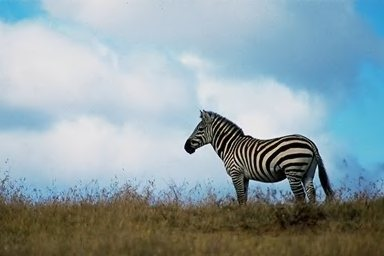

In [3]:
real_image_path = 'CASIA2\Au\Au_ani_00001.jpg'
Image.open(real_image_path)

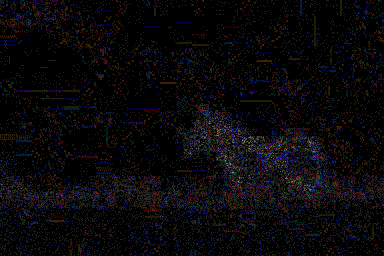

In [4]:
convert_to_ela_image(real_image_path, 95)


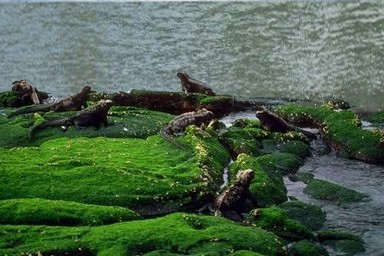

In [5]:
fake_image_path = 'CASIA2\Tp\Tp_D_CND_M_N_ani00018_sec00096_00138.tif'
Image.open(fake_image_path)

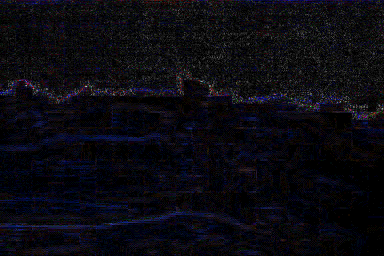

In [6]:
convert_to_ela_image(fake_image_path, 90)


In [7]:
image_size = (224, 224)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0
X = []
y = []


In [8]:
import random

path = 'CASIA2\Au'
print(os.walk(path))
for root, dirs, files in os.walk(path):
  for filename in files:
    file_path = os.path.join(root, filename)
    if filename.lower().endswith(('jpg', 'png')):
      X.append(prepare_image(file_path))
      y.append(1)
    if len(X)==3000:
        break

random.shuffle(X)

print(len(X), len(y))


<generator object _walk at 0x000001F089FF3570>
3000 3000


In [10]:
import random
count = 0
path = 'CASIA2\Tp'
for root, dirs, files in os.walk(path):
    for filename in files:
        file_path = os.path.join(root, filename)
        if filename.lower().endswith(('jpg', 'png', 'tif', 'tiff')):
            X.append(prepare_image(file_path))
            y.append(0)
        if len(X)==4500:
            break
print(len(X), len(y))

4500 4500


In [11]:
from keras.utils import to_categorical
X = np.array(X)
y = to_categorical(y, 2)
X = X.reshape(-1, 224, 224, 3)

In [12]:
print(len(X), len(y))

4500 4500


In [13]:
X_test = X[:1000]
Y_test = y[:1000]

y = y[1000:]
X = X[1000:]

In [14]:

X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.2, random_state=5)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

2800 2800
700 700


In [15]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5,mode='max', restore_best_weights=True)


In [16]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from keras.models import Sequential


In [17]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), padding = 'same', activation = 'relu',))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    return model


In [18]:
from keras.layers import BatchNormalization
model = build_model()

c:\Users\Gokul01\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:
epochs = 15
batch_size = 32
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [20]:
hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping])

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.7741 - loss: 6.6298 - val_accuracy: 0.4586 - val_loss: 0.7660
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8390 - loss: 0.8823 - val_accuracy: 0.4586 - val_loss: 0.7559
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8034 - loss: 1.0704 - val_accuracy: 0.4586 - val_loss: 2.9503
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7953 - loss: 0.5251 - val_accuracy: 0.4586 - val_loss: 1.8893
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8328 - loss: 0.4048 - val_accuracy: 0.4614 - val_loss: 1.4552
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.8468 - loss: 0.3609 - val_accuracy: 0.5871 - val_loss: 1.1167
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8656 - loss: 0.3302 - val_accuracy: 0.4943 - val_loss: 0.9352
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8758 - loss: 0.2873 - val_accuracy: 0.9000 - val_

In [21]:
model.evaluate(X_val,Y_val)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.9007 - loss: 0.2819


[0.27327170968055725, 0.9057142734527588]

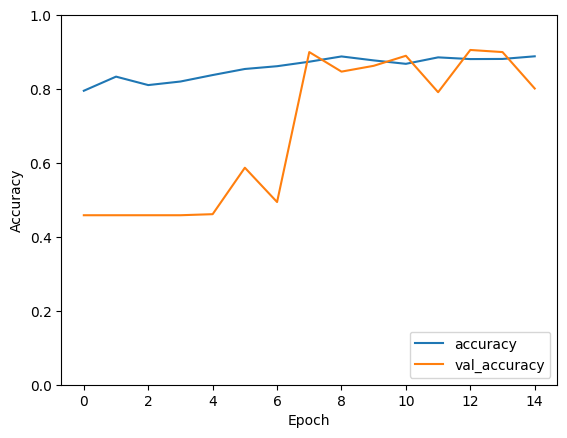

In [24]:
# Plot training history
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()



In [25]:
model.save('Model.h5')